In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [3]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [228]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SSSBBBBB'#BSBSSSBB
meas= 'TOBS'#'PRCP'#'SNOW'#'TMAX'#'TMIN'#'TOBS'#'SNWD'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
1187
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
|          coeff_1|           coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|             res_2|             res_3|           res_mean|    station|total_var|undefs|              vector|  year|
+-----------------+------------------+------------------+---------+--------+--------+---------+-----------+------------------+------------------+------------------+-------------------+-----------+---------+------+--------------------+------+
|740.8056176407199|-68.55173112701863|-78.01423610805493|   2356.1|SSSBBBBB| 39.4047|-105.4767|       TOBS|0.6705305146716039|0.6678120411552373|0.6639883730768652|0.23320970690928777|USC00050454|709

In [229]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT elevation, vector, station, latitude, longitude, year FROM weather\n\tWHERE measurement='%s'"%(meas)
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(5)
df1=df1.rdd.map(lambda row:[np.nanmean(unpackArray(row['vector'],np.float16)), row['elevation'],row['station'],row['latitude'],row['longitude'], row['year']])
#df1=df1.rdd.map(lambda row:[np.max(unpackArray(row['vector'],np.float16)), row['elevation'],row['station'],row['latitude'],row['longitude'], row['year']])
rows=df1.collect()
print (len(rows), len(rows[0]))

SELECT elevation, vector, station, latitude, longitude, year FROM weather
	WHERE measurement='TOBS'
1187 rows
+---------+--------------------+-----------+--------+---------+------+
|elevation|              vector|    station|latitude|longitude|  year|
+---------+--------------------+-----------+--------+---------+------+
|   2356.1|[40 4C 80 51 80 4...|USC00050454| 39.4047|-105.4767|1948.0|
|   2356.1|[90 D5 E0 D8 00 D...|USC00050454| 39.4047|-105.4767|1988.0|
|   2531.1|[90 D5 00 7E 00 D...|USC00058575| 39.6394|-106.3539|1992.0|
|   2302.8|[00 4F 80 51 E0 5...|USC00054234|   39.75|-105.5167|1920.0|
|   1822.7|[E0 D5 38 D9 00 7...|USC00051741| 39.2425|-107.9631|1992.0|
+---------+--------------------+-----------+--------+---------+------+
only showing top 5 rows

(1187, 6)


In [230]:
pd_df = pd.DataFrame(rows, columns=['vector', 'elevation', 'station','latitude','longitude', 'year'])
pd_df = pd_df.replace([np.inf, -np.inf, np.NaN], 0)
#pd_df['TMAX'] = np.max(pd_df['vector'])

In [231]:
pd_df = pd_df.loc[pd_df['vector'] > 0.0]
pd_df = pd_df.loc[pd_df['elevation'] > 0.0]

In [232]:
pd_df.head(10)

,vector,elevation,station,latitude,longitude,year
0,94.312500,2356.1,USC00050454,39.4047,-105.4767,1948.0
1,22.093750,2356.1,USC00050454,39.4047,-105.4767,1988.0
2,30.343750,2531.1,USC00058575,39.6394,-106.3539,1992.0
3,94.875000,2302.8,USC00054234,39.7500,-105.5167,1920.0
4,35.031250,1822.7,USC00051741,39.2425,-107.9631,1992.0
5,30.156250,2097.0,USC00051528,39.2203,-105.2783,2010.0
6,10.281250,2644.1,USC00053530,39.4608,-105.6786,2012.0
7,123.062500,2129.0,USC00052790,39.6381,-105.3150,1964.0
8,125.687500,2097.0,USC00051528,39.2203,-105.2783,1967.0
9,18.140625,2590.8,USS0006K45S,39.6000,-106.5167,2004.0


In [184]:
# Fix the inf....

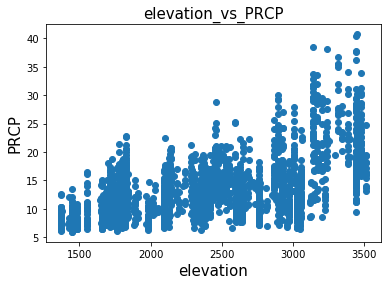

In [185]:
plt.title('elevation_vs_' + meas, fontsize=15)
plt.xlabel('elevation', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['elevation'], (pd_df['vector']))
plt.savefig('g_figures/elevation_vs_' + meas)

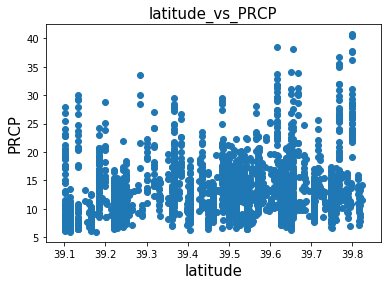

In [186]:
plt.title('latitude_vs_' + meas, fontsize=15)
plt.xlabel('latitude', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['latitude'], pd_df['vector'])
plt.savefig('g_figures/latitude_vs_' + meas)

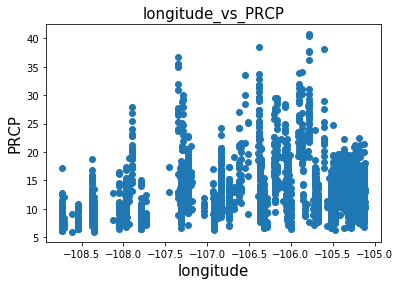

In [187]:
plt.title('longitude_vs_' + meas, fontsize=15)
plt.xlabel('longitude', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['longitude'], pd_df['vector'])
plt.savefig('g_figures/longitude_vs_' + meas)

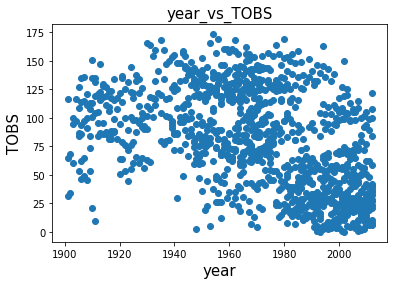

In [233]:
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.scatter(pd_df['year'], pd_df['vector'])
# plt.savefig('g_figures/year_vs_' + meas+'_scatter')

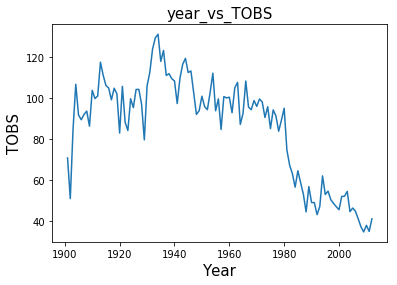

In [234]:
vals = pd_df.groupby(['year'])['vector'].mean()
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.plot(vals.index, vals)
# plt.savefig('g_figures/year_vs_' + meas)

In [194]:
pd_df.groupby(['year'])['vector'].mean()


year
1893.0    15.324219
1894.0    19.308594
1895.0    25.351562
1896.0    13.062500
1897.0    17.640625
1898.0    10.545573
1899.0    20.546875
1900.0     9.433594
1901.0    15.539062
1902.0    11.481771
1903.0    10.516602
1904.0    10.469727
1905.0    10.351997
1906.0    11.916016
1907.0    10.649089
1908.0    10.462054
1909.0    11.205078
1910.0     9.533984
1911.0    10.974392
1912.0    12.010156
1913.0    11.498047
1914.0    11.518555
1915.0     9.888672
1916.0    11.899858
1917.0     9.872396
1918.0    11.392578
1919.0     9.515625
1920.0    11.122396
1921.0    11.951562
1922.0    11.800781
            ...    
1983.0    20.039286
1984.0    17.894866
1985.0    16.150493
1986.0    16.098818
1987.0    14.006168
1988.0    13.773112
1989.0    13.720313
1990.0    14.557617
1991.0    14.520032
1992.0    14.375211
1993.0    16.841283
1994.0    13.766335
1995.0    20.570929
1996.0    19.168497
1997.0    17.379325
1998.0    13.615307
1999.0    14.749479
2000.0    16.892282
2001.0    14.01

In [220]:
aaaaa = ['US1COJF0106',
 'US1COSU0004',
 'US1COSU0007',
 'US1COSU0019',
 'USC00050909',
 'USC00051186',
 'USC00052281',
 'USC00054397',
 'USC00055797',
 'USC00058064',
 'USC00058212',
 'USW00093009']

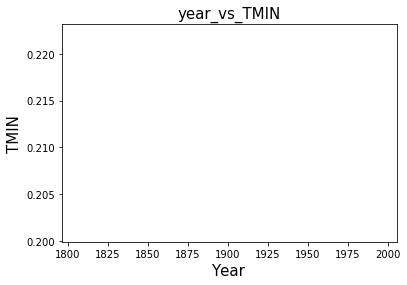

In [227]:
vals = pd_df[pd_df['station'].isin(aaaaa)].groupby(['year'])['vector'].mean()
# vals = pd_df.groupby(['year'])['vector'].mean()
plt.title('year_vs_' + meas, fontsize=15)
plt.xlabel('Year', fontsize=15)
plt.ylabel(meas, fontsize=15)
plt.plot(vals.index, vals/10)
# plt.savefig('g_figures/year_vs_' + meas)




In [191]:
# Global warming in p-value

In [192]:
pd_df[pd_df['station'].isin(['USC00329333'])]

,vector,elevation,station,latitude,longitude,year
